### Setup

In [1]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

## Vanishing and Exploding Gradients

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


[]

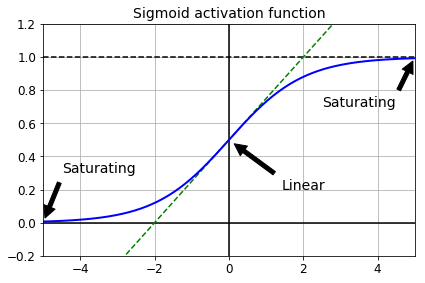

In [7]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), 'b-', linewidth=2)
props = dict(facecolor="black", shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.plot()

In [8]:
import tensorflow as tf

C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                         kernel_initializer=he_init, name="hidden1")

## Nonsaturating Activation Functions

### Leaky ReLU

In [11]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


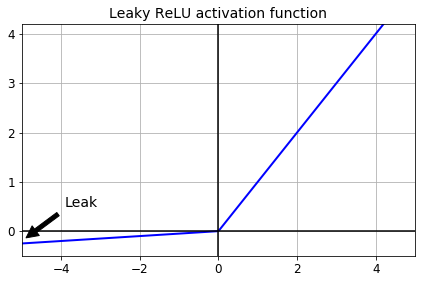

In [13]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5,-0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in Tensorflow

In [14]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [15]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Training a neural network on MNSIT using Leaky ReLU.

In [21]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [22]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [23]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [25]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [26]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [34]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuray = tf.reduce_mean(tf.cast(correct, tf.float32))

In [28]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data

In [30]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [31]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, batch_size):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [37]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch%5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy", acc_batch, "Validation accuracy", acc_valid)
            
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy 0.4409091 Validation accuracy 0.4606
5 Batch accuracy 0.8127273 Validation accuracy 0.823
10 Batch accuracy 0.8709091 Validation accuracy 0.8754
15 Batch accuracy 0.90090907 Validation accuracy 0.8948
20 Batch accuracy 0.8972727 Validation accuracy 0.9044
25 Batch accuracy 0.91 Validation accuracy 0.9102
30 Batch accuracy 0.89272726 Validation accuracy 0.9154
35 Batch accuracy 0.90636367 Validation accuracy 0.9186


### ELU

In [42]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


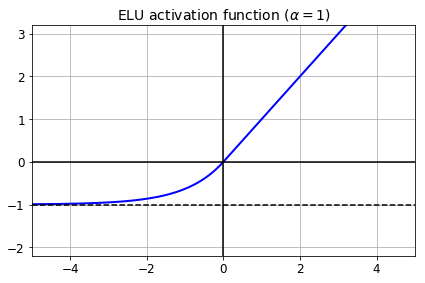

In [43]:
plt.plot(z, elu(z), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig('elu_plot')
plt.show()

Implementing ELU in tensorflow

In [44]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [45]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU

In [46]:
def selu(z,
        scale=1.0507009873554804934193349852946,
        alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)    

Saving figure selu_plot


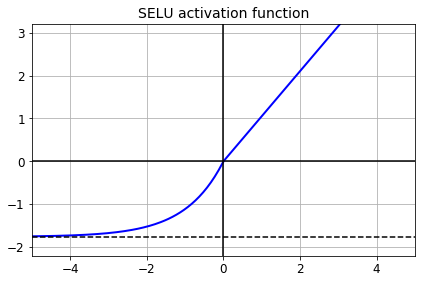

In [48]:
plt.plot(z, selu(z), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig('selu_plot')
plt.show()

In [50]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


In [51]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

Neural Network for MNIST using SELU activation function

In [52]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

In [56]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy", acc_batch, "Validation accuracy", acc_valid)
            
    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy 0.80545455 Validation accuracy 0.8184
5 Batch accuracy 0.90181816 Validation accuracy 0.8974
10 Batch accuracy 0.9 Validation accuracy 0.9114
15 Batch accuracy 0.92454547 Validation accuracy 0.9184
20 Batch accuracy 0.92454547 Validation accuracy 0.924
25 Batch accuracy 0.9418182 Validation accuracy 0.9272
30 Batch accuracy 0.94 Validation accuracy 0.9302
35 Batch accuracy 0.95181817 Validation accuracy 0.9324


## Batch Normalization 

In [58]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name="training")

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

In [59]:
from functools import partial

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name="training")

my_batch_norm_layer = partial(tf.layers.batch_normalization,training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [63]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name="training")

with tf.name_scope('dnn'):
    he_init = tf.variance_scaling_initializer()
    
    my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=batch_norm_momentum)
    
    my_dense_layer = partial(tf.layers.dense, kernel_initializer=he_init)
    
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = tf.nn.elu(my_batch_norm_layer(logits_before_bn))
    
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy)
    
learning_rate = 0.01

with tf.name_scope("training"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [68]:
n_epochs = 20
batch_size = 200

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    saver_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.7654
1 Validation accuracy: 0.8428
2 Validation accuracy: 0.8706
3 Validation accuracy: 0.8882
4 Validation accuracy: 0.8952
5 Validation accuracy: 0.9
6 Validation accuracy: 0.9052
7 Validation accuracy: 0.911
8 Validation accuracy: 0.9128
9 Validation accuracy: 0.9146
10 Validation accuracy: 0.9164
11 Validation accuracy: 0.9208
12 Validation accuracy: 0.9184
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.924
15 Validation accuracy: 0.9242
16 Validation accuracy: 0.9242
17 Validation accuracy: 0.9272
18 Validation accuracy: 0.9288
19 Validation accuracy: 0.9272


In [69]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [70]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Gradient Clipping 

In [71]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy)

In [72]:
learning_rate = 0.01

In [74]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)

capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
             for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [75]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [77]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [78]:
n_epochs = 20
batch_size = 200

In [80]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Validation accuracy:", accuracy_val)
    
    save_path = saver.save(sess, './my_model_final.ckpt')

0 Validation accuracy: 0.27272728
1 Validation accuracy: 0.6363636
2 Validation accuracy: 0.8290909
3 Validation accuracy: 0.85818183
4 Validation accuracy: 0.9054545
5 Validation accuracy: 0.8909091
6 Validation accuracy: 0.93454546
7 Validation accuracy: 0.93454546
8 Validation accuracy: 0.93454546
9 Validation accuracy: 0.9490909
10 Validation accuracy: 0.93454546
11 Validation accuracy: 0.9309091
12 Validation accuracy: 0.93454546
13 Validation accuracy: 0.9563636
14 Validation accuracy: 0.9709091
15 Validation accuracy: 0.94545454
16 Validation accuracy: 0.9709091
17 Validation accuracy: 0.95272726
18 Validation accuracy: 0.91636366
19 Validation accuracy: 0.9563636


## Reusing Pretrained  Layers

## Reusing the TensorFlow Model

In [81]:
reset_graph()

In [82]:
saver = tf.train.import_meta_graph('./my_model_final.ckpt.meta')

In [83]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

save/RestoreV2/shape_and_slices
save/RestoreV2/tensor_names
save/SaveV2/shape_and_slices
save/SaveV2/tensor_names
save/Const
save/RestoreV2
eval/Const
eval/in_top_k/InTopKV2/k
GradientDescent/learning_rate
clip_by_value_11/clip_value_max
clip_by_value_11/clip_value_min
clip_by_value_10/clip_value_max
clip_by_value_10/clip_value_min
clip_by_value_9/clip_value_max
clip_by_value_9/clip_value_min
clip_by_value_8/clip_value_max
clip_by_value_8/clip_value_min
clip_by_value_7/clip_value_max
clip_by_value_7/clip_value_min
clip_by_value_6/clip_value_max
clip_by_value_6/clip_value_min
clip_by_value_5/clip_value_max
clip_by_value_5/clip_value_min
clip_by_value_4/clip_value_max
clip_by_value_4/clip_value_min
clip_by_value_3/clip_value_max
clip_by_value_3/clip_value_min
clip_by_value_2/clip_value_max
clip_by_value_2/clip_value_min
clip_by_value_1/clip_value_max
clip_by_value_1/clip_value_min
clip_by_value/clip_value_max
clip_by_value/clip_value_min
gradients_1/loss/SparseSoftmaxCrossEntropyWithLogi

In [86]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [88]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [89]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

In [90]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

In [91]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

0 Validation accuracy: 0.9564
1 Validation accuracy: 0.9566
2 Validation accuracy: 0.9584
3 Validation accuracy: 0.9598
4 Validation accuracy: 0.96
5 Validation accuracy: 0.958
6 Validation accuracy: 0.9618
7 Validation accuracy: 0.9636
8 Validation accuracy: 0.9628
9 Validation accuracy: 0.9642
10 Validation accuracy: 0.9658
11 Validation accuracy: 0.9658
12 Validation accuracy: 0.964
13 Validation accuracy: 0.967
14 Validation accuracy: 0.9664
15 Validation accuracy: 0.9674
16 Validation accuracy: 0.968
17 Validation accuracy: 0.9682
18 Validation accuracy: 0.968
19 Validation accuracy: 0.9664


In [95]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4, n_outputs, name="ouputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)

capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]

training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()    

In [97]:
with tf.Session() as sess:
    saver.restore(sess, './my_model_final.ckpt')
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)
        
    save_path = saver.save(sess, './my_new_model_final.ckpt')

NotFoundError: Key ouputs/bias not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 592, in launch_instance
    app.start()
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-95-6436c8495a40>", line 39, in <module>
    saver = tf.train.Saver()
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1338, in __init__
    self.build()
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 835, in _build_internal
    restore_sequentially, reshape)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 472, in _AddRestoreOps
    restore_sequentially)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 886, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1546, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\Users\Sid\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key ouputs/bias not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]
